In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torchtext.data import Field
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# There are no repeated batch_id values --> we can use them as IDs

In [3]:
path = 'sentiment/combined/paired/{}_paired.tsv'
train_path = path.format('train')
val_path = path.format('dev')
test_path = path.format('test')

train_df = pd.read_table(train_path)
val_df = pd.read_table(val_path)
test_df = pd.read_table(test_path)

all_ids = np.concatenate((train_df['batch_id'].unique(), val_df['batch_id'].unique(), test_df['batch_id'].unique()))
print(f'unique IDs across all 3 sets: {len(np.unique(all_ids))}')
sum_of_all = len(train_df['batch_id'].unique()) + len(val_df['batch_id'].unique()) + len(test_df['batch_id'].unique())
print(f"sum of unique IDs in each: {sum_of_all}")

unique IDs across all 3 sets: 2440
sum of unique IDs in each: 2440


# Preprocessing

/usr/local/anaconda3/envs/termpro/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


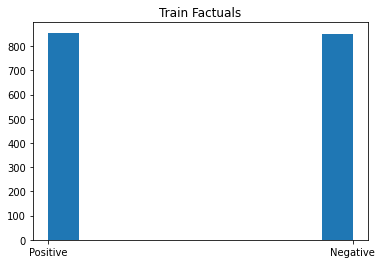

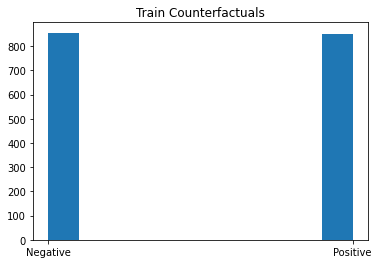

In [14]:
# load data
path = 'sentiment/combined/paired/{}_paired.tsv'
train_path = path.format('train')
val_path = path.format('dev')
test_path = path.format('test')

train_df = pd.read_table(train_path)
val_df = pd.read_table(val_path)
test_df = pd.read_table(test_path)

# build text/label fields on factual and counterfactual data
all_train_texts = train_df["Text"].tolist()
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
text_field.build_vocab(all_train_texts, min_freq=3)

# setup tokenizer
tokenizer = Tokenizer(num_words=len(text_field.vocab), oov_token=True)
tokenizer.fit_on_texts(all_train_texts)

# split into factual and counterfactual
# we'll do this now for simplicity, at the cost of some copy-pasting below
train_IDs = train_df['batch_id'].values
val_IDs = val_df['batch_id'].values
test_IDs = test_df['batch_id'].values

indices = list(range(len(train_df)))
factual_indices, counterfactual_indices = train_test_split(indices, test_size=0.5, stratify=train_IDs)
cf_train_df = train_df.iloc[counterfactual_indices]
train_df = train_df.iloc[factual_indices]

plt.hist(train_df['Sentiment'])
plt.title('Train Factuals')
plt.figure()
plt.hist(cf_train_df['Sentiment'])
plt.title('Train Counterfactuals')
plt.show()

indices = list(range(len(val_df)))
factual_indices, counterfactual_indices = train_test_split(indices, test_size=0.5, stratify=val_IDs)
cf_val_df = val_df.iloc[counterfactual_indices]
val_df = val_df.iloc[factual_indices]

indices = list(range(len(test_df)))
factual_indices, counterfactual_indices = train_test_split(indices, test_size=0.5, stratify=test_IDs)
cf_test_df = test_df.iloc[counterfactual_indices]
test_df = test_df.iloc[factual_indices]


# load text, labels, and IDs
train_IDs = train_df['batch_id'].tolist()
val_IDs = val_df['batch_id'].tolist()
test_IDs = test_df['batch_id'].tolist()

cf_train_IDs = cf_train_df['batch_id'].tolist()
cf_val_IDs = cf_val_df['batch_id'].tolist()
cf_test_IDs = cf_test_df['batch_id'].tolist()

train_texts = train_df['Text'].tolist()
val_texts = val_df['Text'].tolist()
test_texts = test_df['Text'].tolist()

cf_train_texts = cf_train_df['Text'].tolist()
cf_val_texts = cf_val_df['Text'].tolist()
cf_test_texts = cf_test_df['Text'].tolist()

train_labels = (train_df['Sentiment'] == 'Positive').tolist()
val_labels = (val_df['Sentiment'] == 'Positive').tolist()
test_labels = (test_df['Sentiment'] == 'Positive').tolist()

# tokenize, convert to sequences, and pad
# note: using the same padding for factual/counterfactual dataset pairs 
#       not sure on this for val/test
train_sequences = tokenizer.texts_to_sequences(train_texts)
cf_train_sequences = tokenizer.texts_to_sequences(cf_train_texts)
train_padding = max([len(i) for i in train_sequences] + 
                    [len(j) for j in cf_train_sequences])
train_data = pad_sequences(train_sequences, maxlen=train_padding, padding='post')
cf_train_data = pad_sequences(cf_train_sequences, maxlen=train_padding, padding='post')

val_sequences = tokenizer.texts_to_sequences(val_texts)
cf_val_sequences = tokenizer.texts_to_sequences(cf_val_texts)
val_padding = max([len(i) for i in val_sequences] + 
                  [len(j) for j in cf_val_sequences])
val_data = pad_sequences(val_sequences, maxlen=val_padding, padding='post')
cf_val_data = pad_sequences(cf_val_sequences, maxlen=val_padding, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_texts)
cf_test_sequences = tokenizer.texts_to_sequences(cf_test_texts)
test_padding = max([len(i) for i in test_sequences] + 
                   [len(j) for j in cf_test_sequences])
test_data = pad_sequences(test_sequences, maxlen=test_padding, padding='post')
cf_test_data = pad_sequences(cf_test_sequences, maxlen=test_padding, padding='post')

# Iterating with IDs 

In [15]:
batch_size = 32
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

def get_dataloader(data, labels, batch_size):
    # Returns batch_size chunks of (encoded text, ID of text, label of text)
    batches = []
    for i in range(0, len(data), batch_size):
        text_tensor = torch.tensor(data[i:i + batch_size], device=device, dtype=torch.long)
        labels_tensor = torch.tensor(labels[i:i + batch_size], device=device, dtype=torch.float)
        batches.append((text_tensor, labels_tensor))
    return batches

def get_cf_dataloader(data, data_IDs, cf_data, cf_IDs, labels, batch_size):
    # Returns batch_size chunks of (encoded text, ID of text, label of text)
    batches = []
    for i in range(0, len(data), batch_size):
        text_tensor = torch.tensor(data[i:i + batch_size], device=device, dtype=torch.long)
        labels_tensor = torch.tensor(labels[i:i + batch_size], device=device, dtype=torch.float)
        
        cf_indices = [cf_IDs.index(data_ID) for data_ID in data_IDs[i:i + batch_size]]
        cf_text_tensor = torch.tensor(cf_data[cf_indices], device=device, dtype=torch.long)
        
        batches.append((text_tensor, cf_text_tensor, labels_tensor))
    return batches

train_loader = get_cf_dataloader(train_data, train_IDs, cf_train_data, cf_train_IDs, train_labels, batch_size)
val_loader = get_dataloader(val_data, val_labels, batch_size)
# val_loader = get_cf_dataloader(val_data, val_IDs, cf_val_data, cf_val_IDs, val_labels, batch_size)
test_loader = get_dataloader(test_data, test_labels, batch_size)
# test_loader = get_cf_dataloader(test_data, test_IDs, cf_test_data, cf_test_IDs, test_labels, batch_size)

In [16]:
def clp_loss(criterion, output, labels, cf_output, lambda_coef):
    counterfactual_loss = (output - cf_output).abs().sum()
    loss = criterion(output, labels) - lambda_coef * counterfactual_loss
    return loss

In [18]:
lambda_coef = 1
criterion = torch.nn.BCELoss()

for text, cf_text, labels in train_loader:
    
    # get factual predictions
    output = torch.ones(labels.size())  # placeholder for model.predict(text)
    
    # get counterfactual predictions
    cf_output = torch.ones(labels.size())  # placeholder for model.predict(cf_text)
    
    # compute CLP loss
    loss = clp_loss(criterion, output, labels, cf_output, lambda_coef)
    
    print(loss)

tensor(40.6250)
tensor(59.3750)
tensor(53.1250)
tensor(50.)
tensor(46.8750)
tensor(56.2500)
tensor(50.)
tensor(40.6250)
tensor(46.8750)
tensor(50.)
tensor(65.6250)
tensor(43.7500)
tensor(50.)
tensor(50.)
tensor(53.1250)
tensor(50.)
tensor(65.6250)
tensor(46.8750)
tensor(56.2500)
tensor(53.1250)
tensor(53.1250)
tensor(40.6250)
tensor(25.)
tensor(46.8750)
tensor(56.2500)
tensor(62.5000)
tensor(43.7500)
tensor(53.1250)
tensor(53.1250)
tensor(53.1250)
tensor(56.2500)
tensor(50.)
tensor(62.5000)
tensor(59.3750)
tensor(46.8750)
tensor(43.7500)
tensor(59.3750)
tensor(53.1250)
tensor(40.6250)
tensor(50.)
tensor(43.7500)
tensor(37.5000)
tensor(37.5000)
tensor(56.2500)
tensor(46.8750)
tensor(53.1250)
tensor(37.5000)
tensor(34.3750)
tensor(62.5000)
tensor(50.)
tensor(50.)
tensor(46.8750)
tensor(53.1250)
tensor(36.3636)
